# Gaussian mixture distribution and cluster size estimation

## Pythonic setup



In [3]:
import numpy as np
np.random.seed(1)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

%matplotlib inline
import seaborn as sns
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
N = 500
a_true = 0.4
m1 = 0
s1 = 1
m2 = 3
s2 = 1

Y = pd.DataFrame(np.concatenate((np.random.normal(m1, s1, int(N*(1-a_true))), np.random.normal(m2, s2, int(N*a_true)))))

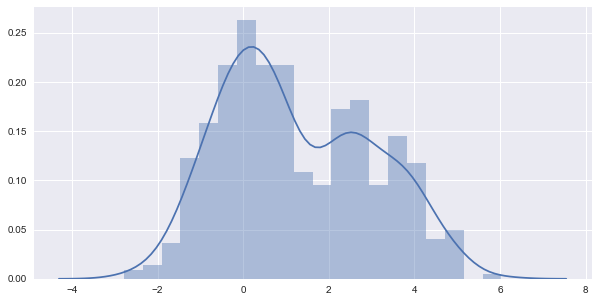

In [5]:
sns.distplot(Y, bins=20)

In [6]:
def sample_mu(y, z, s, target):
    mask = [x == target for x in z]
    my = np.ma.masked_array(y, mask=mask)
    mn = len(my)
    
    mean = np.sum(my) / mn
    variance = s * s / mn
    return np.random.normal(mean, np.sqrt(variance))

In [7]:
def sample_s(y, z, mu, target):
    mask = [x == target for x in z]
    my = np.ma.masked_array(y, mask=mask)
    mn = len(my)
    
    alpha = mn / 2 + 1
    residuals = my - mu
    beta = np.sum(residuals * residuals) / 2
    tau = np.random.gamma(alpha, 1 / beta)
    return 1 / np.sqrt(tau)

In [158]:
def gibbs(y, iters, init):
    mu = init["mu"]
    s = init["s"]
    w = init["w"]
    z = init["z"]
    N = len(y)
    NC = len(mu)
    
    trace = np.zeros((iters, 2*NC)) 
    log_likelihoods = np.zeros((iters, N))
    
    for i in range(iters):
        for c in range(NC):
            mu[c] = sample_mu(y, z, s[c], c)
            s[c] = sample_s(y, z, mu[c], c)
        sample_and_update_z(y, mu, s, w, z, NC)
        w = sample_w(z, w, NC)

        trace[i, :] = np.concatenate((mu, s))
        
        # norm = sp.stats.norm(mu, s)
        # log_likelihoods[i, :] = np.array([np.log(norm.pdf(x)) for x in y])
    
    trace = pd.DataFrame(trace)
    # trace.columns = ['mu', 's']
    
    # log_likelihoods = pd.DataFrame(log_likelihoods)
    
    return trace, log_likelihoods

In [159]:
init = {
    "mu": np.random.uniform(-100, 100, 2),
    "s": np.random.uniform(-100, 100, 2),
    "w": np.random.dirichlet(np.ones(2),size=1)[0],
    "z": np.random.randint(0, 2, N)}
print(init)

{'mu': array([-44.10635897, -84.53781457]), 's': array([ 53.2471388 , -90.38178977]), 'w': array([ 0.18620342,  0.81379658]), 'z': array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1,

In [163]:
def sample_and_update_z(y, mu, s, w, z, NC):
    norms = [sp.stats.norm(mu[x], s[x]) for x in range(NC)]

    for i in range(len(y)):
        ds = np.array([w[j] * norms[j].pdf(y[i]) for j in range(NC)])
        z[i] = np.random.choice(NC, 1, p=ds/np.sum(ds))

In [164]:
def sample_w(z, w, NC):
    s = np.array([np.sum(z == i) for i in range(NC)])
    return(np.random.dirichlet(s, 1)[0])

In [167]:
trace, _ = gibbs(Y[0], 40, init)

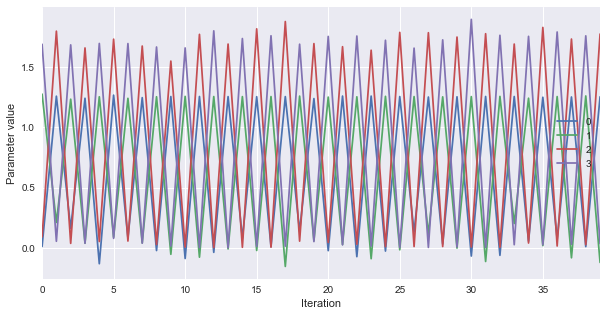

In [169]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

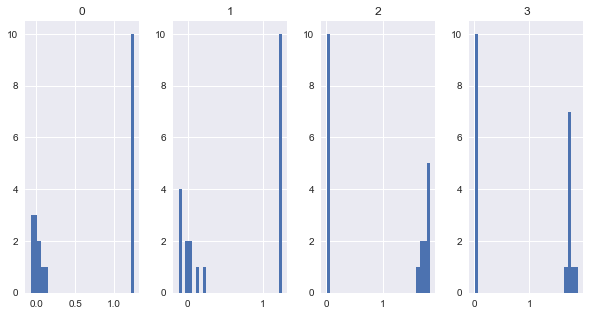

In [171]:
trace_burnt = trace[int(len(trace)/2):]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,4))